In [1]:
import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
import s3dexp.db

In [7]:
df = pd.read_sql(
    'SELECT t1.path, size, rand_read_ms, seq_read_ms, disk FROM ImageMeta t1 JOIN DiskReadProfile t2 ON t1.path=t2.path', 
    s3dexp.db.engine)

In [8]:
df.head()

,path,size,rand_read_ms,seq_read_ms,disk
0,/mnt/hdd/fast20/jpeg/flickr2500/0018efea055a5b...,51071,7.548809,0.213146,hdd
1,/mnt/hdd/fast20/jpeg/flickr2500/00a203ffb7d3d5...,89774,4.564047,0.427008,hdd
2,/mnt/hdd/fast20/jpeg/flickr2500/005b717bdb1151...,79589,9.124994,10.435104,hdd
3,/mnt/hdd/fast20/jpeg/flickr2500/003c5a53bd2e6d...,84876,0.478983,0.337124,hdd
4,/mnt/hdd/fast20/jpeg/flickr2500/006eee87ab62d0...,39755,9.356022,0.208139,hdd


<IPython.core.display.Javascript object>


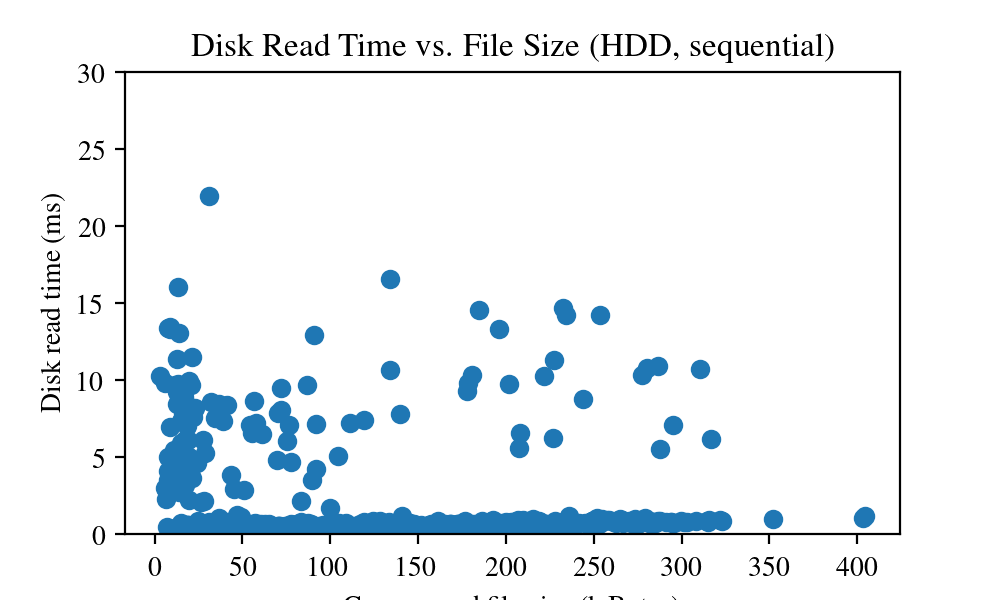

<IPython.core.display.Javascript object>


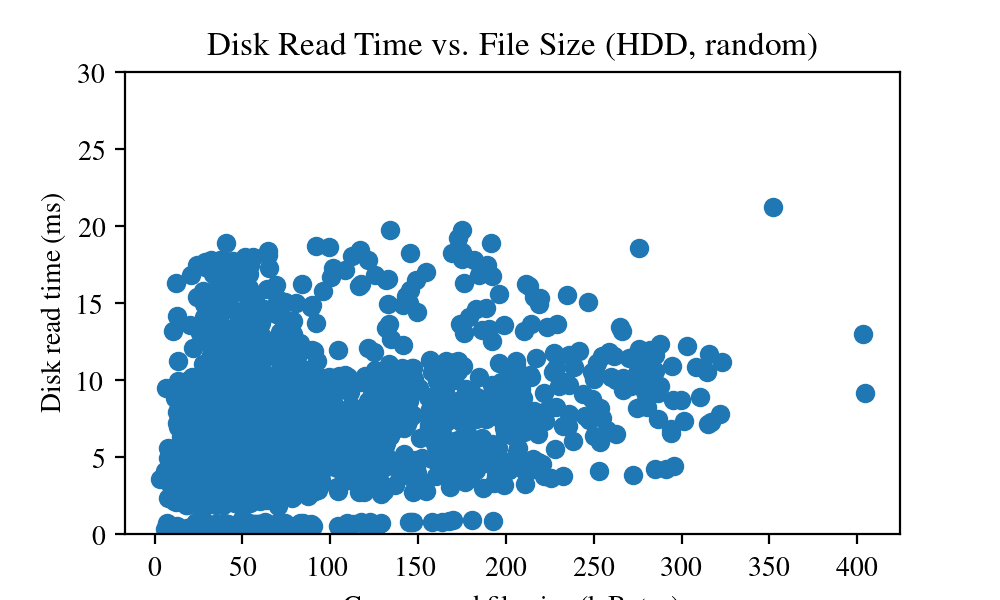

<IPython.core.display.Javascript object>


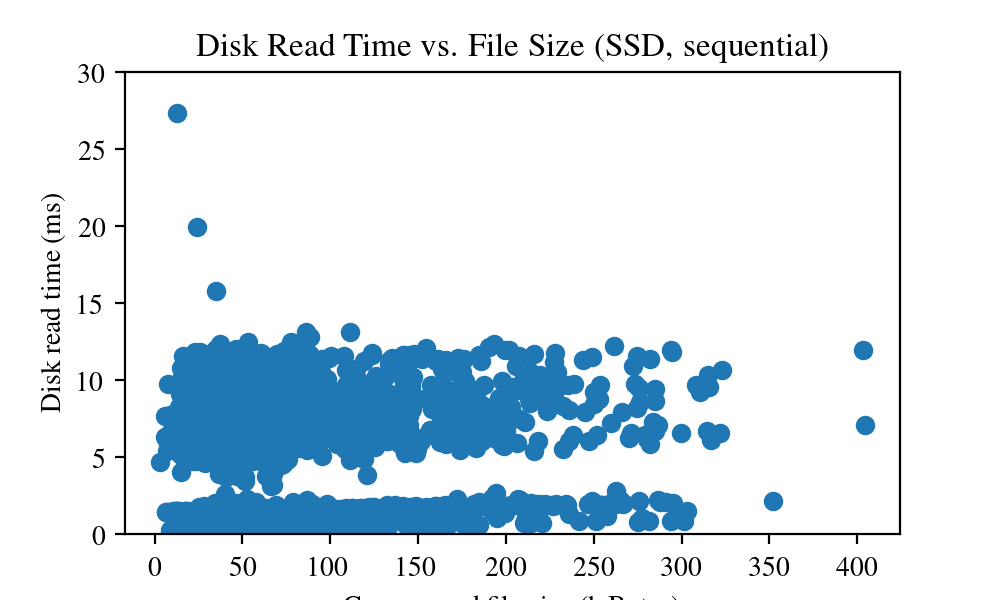

<IPython.core.display.Javascript object>


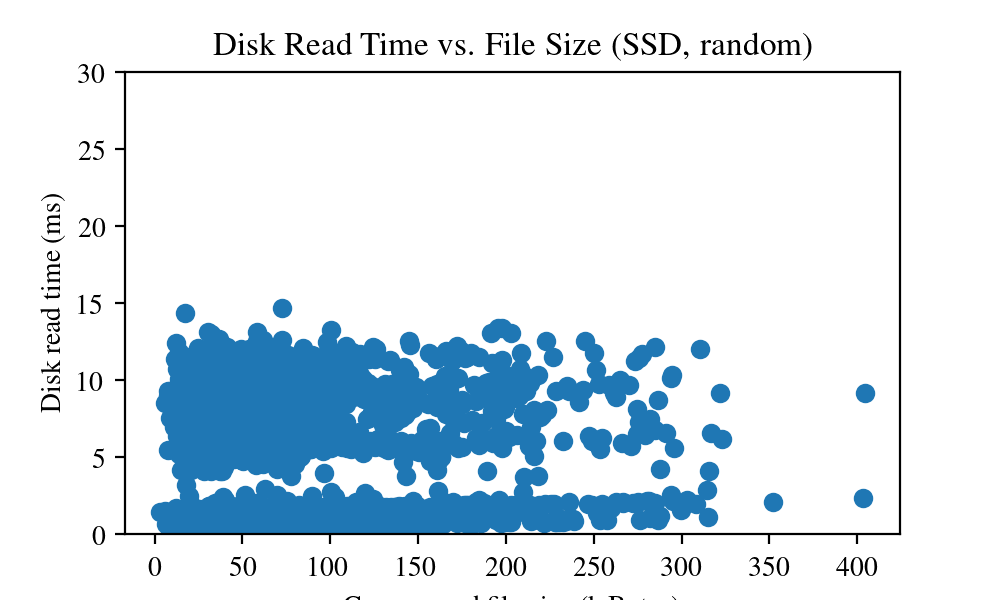

In [15]:
%matplotlib notebook

for disk, disk_text in [('hdd', 'HDD'), ('ssd', 'SSD'),]:
    df = pd.read_sql(
    'SELECT size, rand_read_ms, seq_read_ms, disk \
        FROM DiskReadProfile \
        WHERE disk=%s', 
    s3dexp.db.engine,
    params=[disk,])
    for seq_text, seq_col in [('sequential', 'seq_read_ms'), ('random', 'rand_read_ms')]:
        plt.figure(figsize=(5,3))
        plt.scatter(df['size'] / 1024, df[seq_col])
        plt.xlabel('Compressed file size (k Bytes)')
        plt.ylabel('Disk read time (ms)')
        plt.title('Disk Read Time vs. File Size ({}, {})'.format(disk_text, seq_text))
        plt.ylim(0, 30)
        plt.savefig('readtime-filesize-{}-{}.pdf'.format(disk_text, seq_text), bbox_inches ='tight')